# Make dictionary

In [1]:
import pandas as pd
import torch
from transformers import (
    AutoTokenizer, 
    AutoModel, 
    AutoModelForSequenceClassification, 
    DataCollatorForTokenClassification, 
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer, 
    DataCollatorForLanguageModeling
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from transformers.models.bert.configuration_bert import BertConfig 
import numpy as np
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
#from training_args_module import training_args
import transformers
import os
import csv
from Bio import SeqIO
import argparse
import json
import pickle

import matplotlib.pyplot as plt
from collections import Counter

/home/ns5404/.conda/envs/dna/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
princeton_id = 'ns5404'
project_dir = f'/scratch/gpfs/{princeton_id}/QCB557_project'

# use gpu
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model_out_dir = '/scratch/gpfs/ns5404/QCB557_project/models/replicate_043024/rep1/fine_tune_parallel_v1'

In [4]:
config_seq = BertConfig.from_pretrained(f'/scratch/gpfs/{princeton_id}/QCB557_project/models/replicate_043024/rep1/fine_tune_parallel_v1/config.json', output_attentions=True)
print(config_seq.num_labels) #2 labels
model_seq = AutoModelForSequenceClassification.from_pretrained(model_out_dir, trust_remote_code=True, config=config_seq)
model_seq.to(device)

2


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_features=768

In [5]:
config_base = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M", output_hidden_states=True, output_attentions=True)
print(config_base.num_labels) #2 labels
model_base = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True, config=config_base)
model_base.to(device)

2


Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should prob

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(4096, 768, padding_idx=0)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertUnpadAttention(
          (self): BertUnpadSelfAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (mlp): BertGatedLinearUnitMLP(
          (gated_layers): Linear(in_features=768, out_features=6144, bias=False)
          (act): GELU(approximate='none')
          

In [6]:
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True, padding=True)
tokenizer.pad_token = "X"

In [7]:
test = pd.read_csv(f'/scratch/gpfs/{princeton_id}/QCB557_project/data/H3K4me3/test.csv')
train = pd.read_csv(f'/scratch/gpfs/{princeton_id}/QCB557_project/data/H3K4me3/train.csv')
full = pd.concat([train, test], ignore_index=True)
full.to_csv(f'/scratch/gpfs/{princeton_id}/QCB557_project/data/H3K4me3/all_seqs.csv')

In [8]:
def get_model_output(model_base, model_seq, tokenizer, dataframe, device):
    results_dict = {}
    counter = 0

    for index, row in dataframe.iterrows():
        sequence = row['sequence']
        label = row['label']
        
        inputs = tokenizer(sequence, padding='max_length', max_length=128, return_tensors='pt').to(device)
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        with torch.no_grad():
            outputs_seq = model_seq(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
            hidden_states = outputs_seq.hidden_states
        
        with torch.no_grad():
            outputs_base = model_base(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
            attention_weights = outputs_base[1]

        key = f'seq_{index}_{label}'
        
        results_dict[key] = {
            "sequence": sequence,
            "input_ids": input_ids.cpu().detach().numpy().tolist(),
            "hidden_states": [tensor.cpu().detach().numpy() for tensor in hidden_states],
            "attention_weights": attention_weights.cpu().detach().numpy().tolist()
        }
        
        counter += 1
        percent = (counter/36799)*100
        
        if counter % 1000 == 0:
            print(f"{percent}% complete!")

    return results_dict

In [9]:
results_dict = get_model_output(model_base, model_seq, tokenizer, full, device)

2.7174651485094703% complete!
5.434930297018941% complete!
8.152395445528411% complete!
10.869860594037881% complete!
13.587325742547351% complete!
16.304790891056822% complete!
19.022256039566294% complete!
21.739721188075762% complete!
24.45718633658523% complete!
27.174651485094703% complete!
29.892116633604175% complete!
32.609581782113644% complete!
35.32704693062311% complete!
38.04451207913259% complete!
40.761977227642056% complete!
43.479442376151525% complete!
46.19690752466099% complete!
48.91437267317046% complete!
51.63183782167994% complete!
54.349302970189406% complete!
57.066768118698874% complete!
59.78423326720835% complete!
62.50169841571782% complete!
65.21916356422729% complete!
67.93662871273676% complete!
70.65409386124622% complete!
73.3715590097557% complete!
76.08902415826518% complete!
78.80648930677464% complete!
81.52395445528411% complete!
84.24141960379357% complete!
86.95888475230305% complete!
89.67634990081253% complete!
92.39381504932199% complete!
95

In [10]:
def save_to_pickle(results_dict, file_path):
    with open(file_path, 'wb') as pickle_file:
        pickle.dump(results_dict, pickle_file)

file_path = f'/scratch/gpfs/{princeton_id}/QCB557_project/data/H3K4me3/results_dict.pkl'
save_to_pickle(results_dict, file_path)

In [3]:
import pickle

def load_from_pickle(file_path):
    with open(file_path, 'rb') as pickle_file:
        return pickle.load(pickle_file)

file_path = f'/scratch/gpfs/{princeton_id}/QCB557_project/data/H3K4me3/results_dict.pkl'
results_dict = load_from_pickle(file_path)

# Printing the first and last key content
first_key = next(iter(results_dict))
last_key = list(results_dict.keys())[-1]

print("First key content:")
print(results_dict[first_key])

print("\nLast key content:")
print(results_dict[last_key])

First key content:
{'sequence': 'ACTACAACTGTTTAGCTACTAACTTGCTTGACATCCAAAGAGCAGGCCAATCACTAGAGAATGTCTGGGATCACTCAGATGGGTACACACAAGGCAGTGGATGTGGTTGTTACCGCCACGACTAGGGTCACTCTCTACCGTGAATTTCGAAATTTCGCGAACTGAGTGCGCCAGCTAGCCATTGCTACCAAGCTAACAAAAGGATCAGGCTGCCCAAACGGACGTAGACTCACTGGGCTCCGTCTAGAGAATGACACGAAACCTCACTCGTTGTTTCCTTCCGAGTGATTAACTAGACGGGAATACTGCCTGGAAATTTTTTCGGAAGAGAAAGTTTCGAATTTTAGTTATTCAGTTTCCCGAAAAAGGAATAAAATATGTACAGATGTAGTTGATCAAAAAAAAGTCTATGGACATCATTCCTACTGAAGGCACAGCTAGTACCTTATTTATTGCTGATGCTTTAGCAGATTTAATCAACTGTCAACAGCAGTGATATT', 'input_ids': [[1, 5, 770, 2084, 105, 79, 1645, 100, 388, 208, 1113, 759, 2059, 54, 1152, 63, 83, 138, 2242, 112, 483, 42, 2222, 3305, 93, 681, 67, 2032, 13, 1276, 16, 286, 685, 2350, 30, 504, 105, 475, 105, 76, 233, 96, 1152, 189, 652, 174, 194, 933, 277, 78, 41, 2039, 414, 409, 190, 40, 395, 130, 13, 875, 84, 37, 846, 25, 236, 74, 45, 122, 446, 299, 31, 480, 69, 77, 115, 736, 2121, 57, 58, 981, 55, 106, 512, 195, 39, 2302, 100, 127, 114, 119, 912, 105, 1591, 

In [ ]:
#metadata table
#row: sequence
#columns: columns for each token position MAPPED to relevant motif OR other motif 
#column for label (postiive or negative)

positive_motifs = {
    443:'CCGG',
    136:'GGCC',
    685:'TCGC',
    46:'TATA',
    405:'GCGA',
    90:'GTCC'
}

negative_motifs = {
    92:'GGGG',
    102:'CCCC',
    247:'GCGG',
    270:'CGTC',
    2787:'CCGC',
    288:'TCGG',
    49:'CAAA'
}

seq_motifs = []
for seq,data in results_dict.items():
    this_input_ids = data['input_ids'][0]
    this_motifs = []
    this_motif_df = pd.DataFrame(0, index=np.arange(1), columns=list(positive_motifs.values()) + list(negative_motifs.values()))
    for input_id in this_input_ids:

        if input_id in positive_motifs.keys():
            this_motif_df[positive_motifs[input_id]]+=1
        elif input_id in negative_motifs.keys():
            this_motif_df[negative_motifs[input_id]]+=1
    
    seq_motifs.append(this_motif_df)

In [ ]:
metadata = pd.concat(seq_motifs, axis=0, ignore_index=True)
metadata.index = list(results_dict.keys())
seq_labels = [x.split('_')[-1] for x in list(metadata.index)]
metadata['label'] = seq_labels

In [21]:
metadata

,CCGG,GGCC,TCGC,TATA,GCGA,GTCC,GGGG,CCCC,GCGG,CGTC,CCGC,TCGG,CAAA,label
seq_0_1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
seq_1_1,0,0,0,0,0,0,0,0,1,0,0,0,2,1
seq_2_0,0,1,0,2,0,0,0,0,0,0,0,1,1,0
seq_3_1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
seq_4_0,0,0,0,1,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seq_36794_0,0,0,0,2,0,0,1,0,0,0,0,0,0,0
seq_36795_0,0,1,1,0,0,0,0,0,0,0,0,1,1,0
seq_36796_1,0,0,0,2,0,0,0,0,0,0,0,0,0,1
seq_36797_0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [4]:
attention_weights_list = []
for seq,data in results_dict.items():
    attention_weights = data['attention_weights'][0]
    attention_weights_list.append(data['attention_weights'][0])

In [5]:
attention_weights_df = pd.DataFrame(attention_weights_list)
attention_weights_df.index = list(results_dict.keys())
attention_weights_df.columns = [f'token{x}' for x in range(attention_weights_df.shape[1])]

In [6]:
attention_weights_df

,token0,token1,token2,token3,token4,token5,token6,token7,token8,token9,...,token758,token759,token760,token761,token762,token763,token764,token765,token766,token767
seq_0_1,-0.032522,0.100148,0.076420,-0.157567,0.062965,0.056881,-0.081867,-0.125345,-0.084231,0.030022,...,0.077126,-0.102132,-0.124511,0.070712,-0.182364,0.008077,0.086188,0.063504,-0.208572,0.099247
seq_1_1,-0.206075,-0.112055,0.189495,-0.043250,0.085213,-0.005046,-0.118300,0.007981,-0.174309,0.026495,...,-0.049977,-0.033070,-0.086459,0.089868,-0.075391,0.016211,0.017905,-0.024126,-0.051418,-0.124430
seq_2_0,0.005041,-0.074771,0.138498,-0.147022,0.022496,-0.040005,-0.114757,-0.042865,-0.064904,0.139035,...,-0.145222,-0.003591,-0.069747,-0.018943,-0.049759,-0.086904,-0.208521,0.005782,-0.105528,0.171591
seq_3_1,-0.063411,-0.046367,0.165053,-0.186918,0.142686,0.024139,0.112270,0.019852,-0.096561,0.095774,...,0.157298,0.013909,-0.113822,0.123731,0.063802,0.025136,0.130669,-0.003218,-0.038655,0.041013
seq_4_0,-0.143239,-0.020165,-0.035699,-0.070073,0.037862,-0.007696,0.039686,-0.045046,-0.038122,0.130154,...,0.054419,-0.088109,0.000829,0.244113,-0.121947,-0.193655,0.012923,0.065000,-0.142052,0.009023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seq_36794_0,-0.040529,-0.027243,0.049510,-0.109186,-0.079591,0.067873,-0.056448,-0.132823,0.072899,0.078888,...,-0.075104,0.044099,-0.200079,-0.008403,-0.200761,-0.103378,-0.052046,0.030204,-0.241164,0.041882
seq_36795_0,-0.144773,-0.004421,-0.045837,-0.044093,-0.040529,0.117609,-0.040332,-0.055713,-0.099332,0.168360,...,0.095482,-0.092578,0.101556,0.134171,-0.026671,-0.137634,-0.062974,-0.003877,0.008743,-0.019693
seq_36796_1,-0.127576,0.114963,-0.007304,0.031992,0.061587,0.135199,0.159116,0.025948,0.044168,0.063425,...,-0.021088,-0.030364,0.129286,0.257476,-0.196695,0.100331,0.033881,-0.097329,-0.124315,0.278342
seq_36797_0,-0.186952,0.051809,0.147141,-0.156388,-0.007874,-0.081571,-0.249528,0.021776,-0.072081,0.232095,...,-0.124757,-0.088907,-0.010179,0.052261,-0.241068,-0.037026,0.049434,0.133872,-0.041585,0.028713


In [20]:
#perform PCA on attention weights matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(attention_weights_df)

# Perform PCA
pca = PCA(n_components=2)  # You can change the number of components as needed
principal_components = pca.fit_transform(scaled_data)

PC_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
PC_df.index = attention_weights_df.index


In [22]:
#run UMAP on attention embeddings (no PCA??)
import umap

reducer = umap.UMAP()
scaled_data = StandardScaler().fit_transform(attention_weights_df)
embedding = reducer.fit_transform(scaled_data)

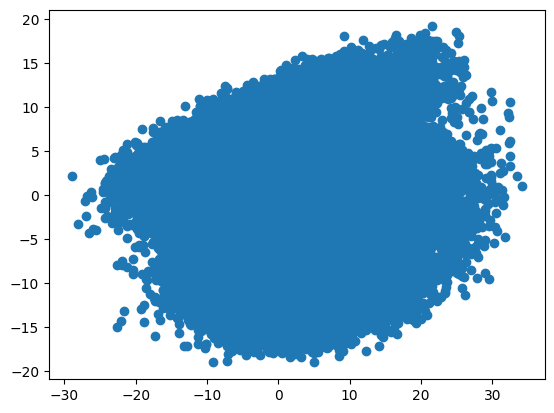

In [29]:
plt.scatter(
    PC_df['PC1'],
    PC_df['PC2']
)

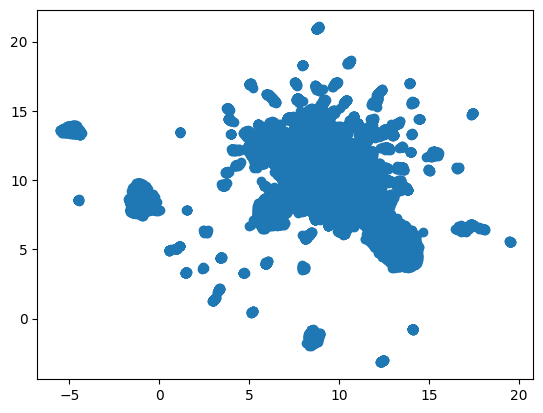

In [25]:
plt.scatter(
    embedding[:,0],
    embedding[:,1]
)